# Fitting a quadriatic form
Here lets consider the problem of optimizing elements of a coefficient matrix $A$ that generates a polynomial through a quadriatic form:
$$Q(x) \equiv y^T A y = ax^2 + 2bx + c$$
where 
$$ A \equiv \begin{bmatrix}
a & b/2 \\
b/2 & c \\
\end{bmatrix}
\quad 
y \equiv \begin{bmatrix} x & 1 \end{bmatrix}^T
$$

In [293]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [323]:
# w = torch.linspace(0,1,41,dtype=torch.float64) # for plotting
w = torch.linspace(0,1,41,dtype=torch.complex128) # for plotting
parameters_ideal = torch.tensor([1,2.5,-2],dtype=torch.float64)
parameters = torch.tensor([0,0,4],dtype=torch.float64,requires_grad=True)

def computeValues(parameters, w):
    L1 = parameters[0]
    C1 = parameters[1]
    G1 = parameters[2]
    
    # Define the coefficient matrix A
    # A = torch.tensor([
    #     [L1, C1 / 2],
    #     [C1 / 2, G1]
    # ], dtype=torch.float64)
    A = torch.tensor([
        [1j*L1, 1+1j*C1 / 2],
        [C1 / 2, G1]
    ], dtype=torch.complex128)
    
    # Build the y tensor for all x values
    y = torch.stack([w**2, torch.ones_like(w)], dim=0)  # Shape: (2, len(xs))
    
    # Compute the polynomial values for all x
    Q = (y.T @ A @ y).diagonal()  # Efficient computation
    return Q

def computeError(parameters):
    polynomial_w = computeValues(parameters,w)
    polynomial_target = computeValues(parameters_ideal,w)
    # loss_real = torch.nn.MSELoss()(torch.real(polynomial_w), torch.real(polynomial_target))
    # loss_imag = nn.MSELoss()(torch.imag(polynomial_w), torch.real(polynomial_target))
    # loss = loss_real+loss_imag
    loss = torch.nn.MSELoss()(polynomial_w,polynomial_target)
    return loss

In [324]:
computeValues(parameters,w)

tensor([4.0000+0.j, 4.0006+0.j, 4.0025+0.j, 4.0056+0.j, 4.0100+0.j, 4.0156+0.j, 4.0225+0.j,
        4.0306+0.j, 4.0400+0.j, 4.0506+0.j, 4.0625+0.j, 4.0756+0.j, 4.0900+0.j, 4.1056+0.j,
        4.1225+0.j, 4.1406+0.j, 4.1600+0.j, 4.1806+0.j, 4.2025+0.j, 4.2256+0.j, 4.2500+0.j,
        4.2756+0.j, 4.3025+0.j, 4.3306+0.j, 4.3600+0.j, 4.3906+0.j, 4.4225+0.j, 4.4556+0.j,
        4.4900+0.j, 4.5256+0.j, 4.5625+0.j, 4.6006+0.j, 4.6400+0.j, 4.6806+0.j, 4.7225+0.j,
        4.7656+0.j, 4.8100+0.j, 4.8556+0.j, 4.9025+0.j, 4.9506+0.j, 5.0000+0.j],
       dtype=torch.complex128)

Iteration 0 : tensor([ 0.5026,  2.0027, -2.4973], dtype=torch.float64, requires_grad=True);  f = 7.015829849202473e-06
Iteration 20 : tensor([ 0.8567,  2.3567, -2.1433], dtype=torch.float64, requires_grad=True);  f = 0.012735859359103532
Iteration 40 : tensor([ 1.0008,  2.5007, -1.9993], dtype=torch.float64, requires_grad=True);  f = 0.0010354777783028815
Iteration 60 : tensor([ 1.0036,  2.5035, -1.9965], dtype=torch.float64, requires_grad=True);  f = 0.00023633384552334635
Iteration 80 : tensor([ 0.9951,  2.4951, -2.0049], dtype=torch.float64, requires_grad=True);  f = 1.7001644793342947e-07
Ideal parameters: tensor([ 1.0000,  2.5000, -2.0000], dtype=torch.float64)


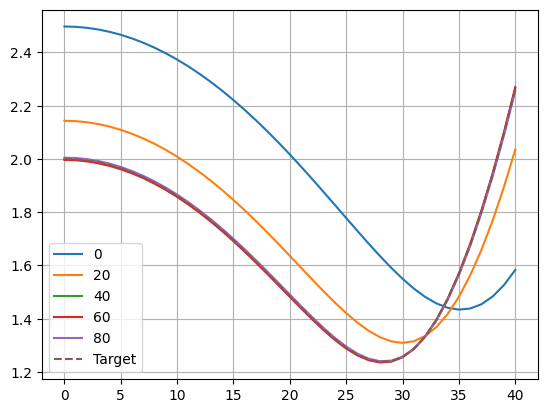

In [328]:
fig, axes = plt.subplots(); legend = []
optimizer = torch.optim.Adam([parameters], lr=0.5) # Adaptive algorithm, better
for i in range(100):
    optimizer.zero_grad()
    # f = computeError(parameters)
    f = torch.nn.MSELoss()(parameters_ideal,parameters)
    f.backward()
    optimizer.step()
    if(i%20==0):# and i> 50):
        print(f'Iteration {i} : {parameters};  f = {f.item()}')
        axes.plot(abs(computeValues(parameters,w)).detach().numpy())
        legend.append(i)
legend.append('Target')
axes.plot(abs(computeValues(parameters_ideal,w)).detach().numpy(),linestyle='dashed')
print(f'Ideal parameters: {parameters_ideal}')
axes.legend(legend)
axes.grid('on')